# Fit the Model and Predict Occupancy

Pull in data and model structure as processed; fit a multi-state model then simulate

Start by defining the model structure (although this is implicit in the data files) for end-user interpretability


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.special as sp
import scipy.optimize as op
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import seaborn as sns

In [2]:
state_names = (
    "Acute Ward",
    "ICU",
    "Recovery Ward",
    "Discharge",
    "Death",
)
nstates = len(state_names)

In [3]:
allowed_transitions = (
    ("Acute Ward", "ICU"),
    ("Acute Ward", "Discharge"),
    ("Acute Ward", "Death"),
    ("ICU", "Recovery Ward"),
    ("ICU", "Death"),
    ("Recovery Ward", "ICU"),
    ("Recovery Ward", "Discharge"),
)
ntrans = len(allowed_transitions)

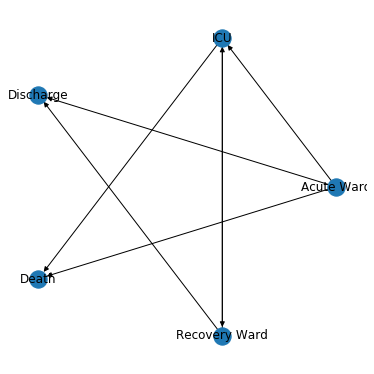

In [4]:
state_dict = {state: loc+1 for loc, state in enumerate(state_names)}
state_name_dict = {loc+1: state for loc, state in enumerate(state_names)}
IJ = [(state_dict[xy[0]],state_dict[xy[1]]) for xy in allowed_transitions]
DG = nx.DiGraph()
DG.add_edges_from(IJ)
plt.figure(figsize=(5,5))
pos=nx.circular_layout(DG)
nx.draw(DG,pos)
nx.draw_networkx_labels(DG,pos,labels=state_name_dict)
plt.show()

In [5]:
Qbase = nx.to_numpy_array(DG,dtype='int',nodelist=range(1,nstates+1))
Qbase # Matrix of allowed transitions: G[i,j] is from i to j

array([[0, 1, 0, 1, 1],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [6]:
nxy = np.shape(Qbase)
TransNum = Qbase.copy()
k=1
for i in range(0,nxy[0]):
    for j in range(0,nxy[1]):
        if (Qbase[i,j] > 0):
            TransNum[i,j] = k
            k +=1
TransNum

array([[0, 1, 0, 2, 3],
       [0, 0, 4, 0, 5],
       [0, 6, 0, 7, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [7]:
def mynll(params, T, C, X, ATF=True):
    kk = params[0]
    bb = params[1:]
    xb = X@bb
    if ATF:
        phik = np.exp(kk*xb)
        return (((T**kk)@phik) - (C) @ (np.log(kk * (T**(kk-1))) + kk*xb))
    else:
        th = np.exp(xb)
        return (((T**kk)@th) - (C) @ (np.log(kk * (T**(kk-1))) + xb))

In [8]:
def get_scale(x, k=1.0, ATF=True):
    # Return a Weibull scale parameter from a linear predictor 
    if ATF:
        return np.exp(-x)
    else:
        return np.exp(-x/k)

In [9]:
df = pd.read_csv('./data_files/Current_COVID.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
census = pd.read_csv('./data_files/census.csv').values

In [10]:
x0 = np.array([1.0, -3.0])
ntrans = np.max(TransNum)
xhats = np.zeros((ntrans, len(x0)))

for k in tqdm(range(0,ntrans)):
    dfk = df[df.TransitionNumber == (k+1)]
    T = dfk.TimeInState.values
    C = dfk.Censored.values

    X = np.atleast_2d(np.ones(len(T)))
    
    myf = lambda x: mynll(x, T, C, X.T)
    fout = op.minimize(myf,x0,method='Nelder-Mead')
    xhat = fout.x
    khat = np.abs(xhat[0])
    scalehat = get_scale(xhat[1]) 
    xhats[k,:] =fout.x

/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [11]:
nboot = 400 # Number of bootstrap samples taken
xboot = np.zeros((nboot, ntrans, len(x0)))
for b in tqdm(range(0,nboot)):
    df = pd.read_csv('./data_files/Current_COVID' + str(b) + '.csv')
    df = df.drop(['Unnamed: 0'], axis = 1)
    for k in range(0,ntrans):
        dfk = df[df.TransitionNumber == (k+1)]
        T = dfk.TimeInState.values
        C = dfk.Censored.values
        
        X = np.atleast_2d(np.ones(len(T)))

        myf = lambda x: mynll(x, T, C, X.T)
        fout = op.minimize(myf,xhat,method='Nelder-Mead')
        xboot[b,k,:] = fout.x

/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [12]:
ld = len(census)
dayrange = range(1,ld+1) # The range of days we care about

In [13]:
# Simulate for comparison with census

counts = np.zeros((nboot,nstates,ld))
np.random.seed(7)
for s in tqdm(range(0,nboot)):
    
    
    kmatb = np.zeros((nstates,nstates))
    scalematb = np.zeros((nstates,nstates))
    for k in range(0,ntrans):
        ij = np.argwhere(TransNum == (k+1))[0]
        kmatb[ij[0],ij[1]] = xboot[s,k,0]
        scalematb[ij[0],ij[1]] = get_scale(xboot[s,k,1])
    adm = np.zeros(ld) 
    adm[0:len(census[:,5])] = census[:,5] # admissions


    for d in dayrange:      
        for i in range(0,int(adm[d-1])):
            prob_ICUstart = 0.0 # Change if non-zero
            rand = np.random.uniform(0,1)
            if (rand<prob_ICUstart):
                y=1
            else:
                y=0

            Yi = np.array([y])
            Ti = np.array([0.0])
            while ((np.sum(Qbase[y,:]) > 0.0) and (Ti[-1]<=ld)):
                zz = np.where(Qbase[y,:] > 0.0)[0]
                tti = np.zeros(len(zz))
                yyi = np.zeros(len(zz))
                for q, z in enumerate(zz):
                    k = kmatb[y,z]
                    scaleg = scalematb[y,z]
                    tti[q] = scaleg*np.random.weibull(k)
                    yyi[q] = z

                r = np.argmin(tti)
                tran = TransNum[y,:][np.nonzero(TransNum[y,:])][r]
                y = int(yyi[r])
                Yi = np.append(Yi,y)
                Ti = np.append(Ti,Ti[-1].copy() + tti[r])
            Zi = [int(np.round(x)) for x in Yi]
            Di = [(d + int(np.round(x))) for x in Ti]
            for m in range(0,len(Di)):
                j = Zi[m]
                if (Di[m]>=ld):
                    break
                if (m==(len(Di)-1)):
                    counts[s,j,Di[m]:] += 1.0
                elif (Di[m+1]>ld):
                    counts[s,j,Di[m]:ld] += 1.0
                else:
                    counts[s,j,Di[m]:Di[m+1]] += 1.0

In [14]:
nb = nboot # Number of census bootstraps 
censusb = []
for b in range(0,nb):
    dfb = pd.read_csv('./data_files/census' + str(b) + '.csv', )
    censusb.append(dfb.values)
censusb = np.array(censusb)

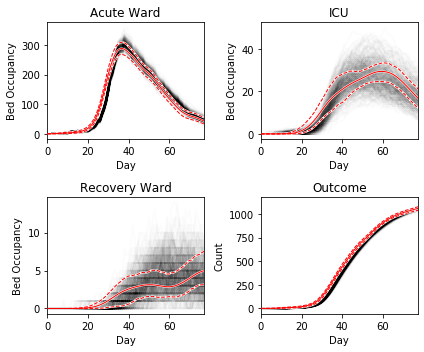

In [15]:
plt.figure(figsize=(6,5))

for i in range(0,3):
    
    plt.subplot(2,2,i+1)
    for s in range(0,nboot):
        plt.plot(dayrange,counts[s,i,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
    z = census[:,i]
    w = np.array([])
    for day in range(0,len(z)):
        w = np.append(w,np.repeat(day, int(z[day])))
    t = range(0, len(z))
    kde = st.gaussian_kde(w)
    plt.plot(t, np.sum(z)*kde(t), c='w', lw=2, zorder=2)
    plt.plot(t, np.sum(z)*kde(t), c='r', lw=1, zorder=3)
    yboot = np.zeros((nb,len(t)))
    for q in range(0,nb):
        zboot = censusb[q,:,i]
        wboot = np.array([])
        for day in range(0,len(zboot)):
            wboot = np.append(wboot,np.repeat(day, int(zboot[day])))
        kdeboot = st.gaussian_kde(wboot)
        yboot[q,:] = kdeboot(t)
    yl = np.sum(z)*np.percentile(yboot,2.5,axis=0)
    yu = np.sum(z)*np.percentile(yboot,97.5,axis=0)
    plt.plot(t, yl, c='w', lw=2, zorder=2)
    plt.plot(t, yl, c='r', ls='--', lw=1, zorder=3)
    plt.plot(t, yu, c='w', lw=2, zorder=2)
    plt.plot(t, yu, c='r', ls='--', lw=1, zorder=3)
    plt.title(state_names[i])
    plt.xlim([0,77])
    plt.xlabel('Day')
    plt.ylabel('Bed Occupancy')
    
plt.subplot(2,2,4)
for s in range(0,nboot):
    plt.plot(dayrange,np.sum(counts[s,[3,4],:],0),c='k',linewidth=2,alpha=0.01,zorder=0)  
z = np.sum(census[:,[3,4]],1)
w = np.array([])
for day in range(0,len(z)):
    w = np.append(w,np.repeat(day, int(z[day])))
kde = st.gaussian_kde(w)
plt.plot(t, np.sum(z)*kde(t), c='w', lw=2, zorder=2)
plt.plot(t, np.sum(z)*kde(t), c='r', lw=1, zorder=3)
yboot = np.zeros((nb,len(t)))
for q in range(0,nb):
    zboot = np.sum(censusb[q,:,[3,4]],0)
    wboot = np.array([])
    for day in range(0,len(zboot)):
        wboot = np.append(wboot,np.repeat(day, int(zboot[day])))
    kdeboot = st.gaussian_kde(wboot)
    yboot[q,:] = kdeboot(t)
yl = np.sum(z)*np.percentile(yboot,2.5,axis=0)
yu = np.sum(z)*np.percentile(yboot,97.5,axis=0)
plt.plot(t, yl, c='w', lw=2, zorder=2)
plt.plot(t, yl, c='r', ls='--', lw=1, zorder=3)
plt.plot(t, yu, c='w', lw=2, zorder=2)
plt.plot(t, yu, c='r', ls='--', lw=1, zorder=3)
plt.title('Outcome')
plt.xlim([0,77])
plt.xlabel('Day')
plt.ylabel('Count')
    
plt.tight_layout()

In [16]:
# Simulate for confidence interval in mean

npat = 10000 # Number of patients to simulate per bootstrap
outdict = {x: np.zeros((nboot,2)) for x in allowed_transitions}
outdict_hat = {x: np.zeros(2) for x in allowed_transitions}
states_to_start = ('Acute Ward', 'ICU', 'Recovery Ward')


kmatb = np.zeros((nstates,nstates))
scalematb = np.zeros((nstates,nstates))
for k in range(0,ntrans):
    ij = np.argwhere(TransNum == (k+1))[0]
    kmatb[ij[0],ij[1]] = xhats[k,0]
    scalematb[ij[0],ij[1]] = get_scale(xhats[k,1])

for i in range(0,npat):
    for ss in states_to_start: # For each patient start in each start state
        y = state_dict[ss]-1

        zz = np.where(Qbase[y,:] > 0.0)[0]
        tti = np.zeros(len(zz))
        yyi = np.zeros(len(zz))
        for q, z in enumerate(zz):
            k = kmatb[y,z]
            scaleg = scalematb[y,z]
            tti[q] = scaleg*np.random.weibull(k)
            yyi[q] = z

        r = np.argmin(tti)

        se = state_names[int(yyi[r])]
        outdict_hat[(ss,se)][0] += tti[r]
        outdict_hat[(ss,se)][1] += 1
        
for s in tqdm(range(0,nboot)):
    
    kmatb = np.zeros((nstates,nstates))
    scalematb = np.zeros((nstates,nstates))
    for k in range(0,ntrans):
        ij = np.argwhere(TransNum == (k+1))[0]
        kmatb[ij[0],ij[1]] = xboot[s,k,0]
        scalematb[ij[0],ij[1]] = get_scale(xboot[s,k,1])

    for i in range(0,npat):
        for ss in states_to_start: # For each patient start in each start state
            y = state_dict[ss]-1

            zz = np.where(Qbase[y,:] > 0.0)[0]
            tti = np.zeros(len(zz))
            yyi = np.zeros(len(zz))
            for q, z in enumerate(zz):
                k = kmatb[y,z]
                scaleg = scalematb[y,z]
                tti[q] = scaleg*np.random.weibull(k)
                yyi[q] = z

            r = np.argmin(tti)
            
            se = state_names[int(yyi[r])]
            outdict[(ss,se)][s,0] += tti[r]
            outdict[(ss,se)][s,1] += 1
            

In [17]:
# Work out probabilities of going to each state
ss = states_to_start[0]
pvec = []
prow  = []
pvecb = []
prowb  = []
for pair, vec in outdict.items():
    if (pair[0] == ss):
        prow.append(outdict_hat[pair][1])
        prowb.append(outdict[pair][:,1])
    else:
        ss = pair[0]
        pvec.append(prow)
        prow = []
        prow.append(outdict_hat[pair][1])
        
        pvecb.append(prowb)
        prowb = []
        prowb.append(outdict[pair][:,1])
pvec.append(prow)
pvecb.append(prowb)

In [18]:
probs = np.array([])
pl = np.array([])
pu = np.array([])
for j in range(0,len(pvec)):
    qvec = np.array(pvec[j])
    qvec /= np.sum(qvec)
    qvec *= 100.0
    qa = np.array(pvecb[j])*(100/npat)
    ql = np.nanpercentile(qa,2.5,1)
    qu = np.nanpercentile(qa,97.5,1)
    probs = np.concatenate([probs,qvec])
    pl = np.concatenate([pl,ql])
    pu = np.concatenate([pu,qu])

In [19]:
j = 0
for pair, vec in outdict.items():
    that = outdict_hat[pair][0]/outdict_hat[pair][1]
    tts = outdict[pair][:,0]/outdict[pair][:,1]
    tlow = np.nanpercentile(tts,2.5)
    tup = np.nanpercentile(tts,97.5)
    print('{} to {}: {:.1f}({:.1f},{:.1f}) days; probability {:.1f}({:.1f},{:.1f})%'.format(
        pair[0], pair[1], that, tlow, tup,probs[j],pl[j],pu[j]))
    j += 1

Acute Ward to ICU: 3.6(2.9,4.9) days; probability 5.2(3.7,6.5)%
Acute Ward to Discharge: 7.9(7.7,8.9) days; probability 68.4(65.5,71.3)%
Acute Ward to Death: 9.3(8.2,10.0) days; probability 26.4(23.9,29.3)%
ICU to Recovery Ward: 23.8(18.8,30.1) days; probability 72.1(59.1,83.5)%
ICU to Death: 19.3(12.9,30.4) days; probability 27.9(16.5,40.9)%
Recovery Ward to ICU: 1.1(0.8,2.4) days; probability 19.8(7.2,31.7)%
Recovery Ward to Discharge: 6.5(4.8,8.2) days; probability 80.2(68.3,92.8)%


/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [20]:
# Simulate for prediction interval of different outcomes at the point estimate

kmatb = np.zeros((nstates,nstates))
scalematb = np.zeros((nstates,nstates))
for k in range(0,ntrans):
    ij = np.argwhere(TransNum == (k+1))[0]
    kmatb[ij[0],ij[1]] = xhats[k,0]
    scalematb[ij[0],ij[1]] = get_scale(xhats[k,1])

In [21]:
# Ward admission to final outcome

npat = 1000000 # Number of patients to simulate
Ti = np.zeros(npat)
was_in_icu = np.zeros(npat)

for i in tqdm(range(0,npat)):
    y=0
    Ti[i] = 0.0
    while (np.sum(Qbase[y,:]) > 0.0):
        zz = np.where(Qbase[y,:] > 0.0)[0]
        tti = np.zeros(len(zz))
        yyi = np.zeros(len(zz))
        for q, z in enumerate(zz):
            k = kmatb[y,z]
            scaleg = scalematb[y,z]
            tti[q] = scaleg*np.random.weibull(k)
            yyi[q] = z

        r = np.argmin(tti)
        y = int(yyi[r])
        if (y==1):
            was_in_icu[i] = 1
        Ti[i] += tti[r]
        
print("Ward to final outcome - prediction region for time including cycles through recovery ward:")

icui = (was_in_icu == 1)

print("If No ICU Stay, n = {:d}:".format(len(np.where(~icui)[0])))
print('Mean: {:.2f}'.format(np.mean(Ti[~icui])))
print('STD: {:.2f}'.format(np.std(Ti[~icui])))
print('50 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti[~icui],25), np.percentile(Ti[~icui],75)))
print('95 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti[~icui],2.5), np.percentile(Ti[~icui],97.5)))

print("If ICU Stay, n = {:d}:".format(len(np.where(icui)[0])))
print('Mean: {:.2f}'.format(np.mean(Ti[icui])))
print('STD: {:.2f}'.format(np.std(Ti[icui])))
print('50 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti[icui],25), np.percentile(Ti[icui],75)))
print('95 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti[icui],2.5), np.percentile(Ti[icui],97.5)))


Ward to final outcome - prediction region for time including cycles through recovery ward:
If No ICU Stay, n = 949316:
Mean: 8.49
STD: 8.84
50 percent interval: (2.28, 11.72)
95 percent interval: (0.18, 32.48)
If ICU Stay, n = 50684:
Mean: 35.00
STD: 24.87
50 percent interval: (16.92, 47.01)
95 percent interval: (3.68, 97.30)


In [22]:
# ICU to first ICU exit

npat = 100000 # Number of patients to simulate
Ti = np.zeros(npat)
for i in tqdm(range(0,npat)):
    y=1
    Ti[i] = 0.0
    zz = np.where(Qbase[y,:] > 0.0)[0]
    tti = np.zeros(len(zz))
    yyi = np.zeros(len(zz))
    for q, z in enumerate(zz):
        k = kmatb[y,z]
        scaleg = scalematb[y,z]
        tti[q] = scaleg*np.random.weibull(k)
        yyi[q] = z
    r = np.argmin(tti)
    Ti[i] += tti[r]
print("ICU to first ICU exit - prediction region for time excluding cycles through recovery ward:")
print('Mean: {:.2f}'.format(np.mean(Ti)))
print('STD: {:.2f}'.format(np.std(Ti)))
print('50 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti,25), np.percentile(Ti,75)))
print('95 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti,2.5), np.percentile(Ti,97.5)))


ICU to first ICU exit - prediction region for time excluding cycles through recovery ward:
Mean: 22.73
STD: 18.75
50 percent interval: (8.62, 31.84)
95 percent interval: (1.10, 70.57)


In [23]:
# ICU to final ICU exit

npat = 100000 # Number of patients to simulate
Ti = np.zeros(npat)
for i in tqdm(range(0,npat)):
    y=1
    Ti[i] = 0.0
    while (np.sum(Qbase[y,:]) > 0.0):
        zz = np.where(Qbase[y,:] > 0.0)[0]
        tti = np.zeros(len(zz))
        yyi = np.zeros(len(zz))
        for q, z in enumerate(zz):
            k = kmatb[y,z]
            scaleg = scalematb[y,z]
            tti[q] = scaleg*np.random.weibull(k)
            yyi[q] = z

        r = np.argmin(tti)
        y = int(yyi[r])
        Ti[i] += tti[r]
print("ICU to final ICU exit - prediction region for time including cycles through recovery ward:")
print('Mean: {:.2f}'.format(np.mean(Ti)))
print('STD: {:.2f}'.format(np.std(Ti)))
print('50 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti,25), np.percentile(Ti,75)))
print('95 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti,2.5), np.percentile(Ti,97.5)))


ICU to final ICU exit - prediction region for time including cycles through recovery ward:
Mean: 31.22
STD: 24.11
50 percent interval: (13.72, 42.50)
95 percent interval: (1.98, 92.55)


In [24]:
# Admission to ICU entry

npat = 100000 # Number of patients to simulate
Ti = np.zeros(npat)
for i in tqdm(range(0,npat)):
    y=0
    Ti[i] = 0.0
    while (y != 1):
        y = 0
        zz = np.where(Qbase[y,:] > 0.0)[0]
        tti = np.zeros(len(zz))
        yyi = np.zeros(len(zz))
        for q, z in enumerate(zz):
            k = kmatb[y,z]
            scaleg = scalematb[y,z]
            tti[q] = scaleg*np.random.weibull(k)
            yyi[q] = z

        r = np.argmin(tti)
        y = int(yyi[r])
    Ti[i] += tti[r]
print("Admission to ICU entry if ICU:")
print('Mean: {:.2f}'.format(np.mean(Ti)))
print('STD: {:.2f}'.format(np.std(Ti)))
print('50 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti,25), np.percentile(Ti,75)))
print('95 percent interval: ({:.2f}, {:.2f})'.format(np.percentile(Ti,2.5), np.percentile(Ti,97.5)))


Admission to ICU entry if ICU:
Mean: 3.75
STD: 5.82
50 percent interval: (0.26, 4.75)
95 percent interval: (0.00, 20.50)
